## Preguntas a responder:
- Cuál es el cliente típico?
- Qué diferencia un comprador de alguien curioso? 
- Cómo se distribuyen las propiedades?

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import geopy

In [160]:
# --- 1. Definir los colores de la marca Colibid ---
# Ajusta estos códigos hexadecimales si tienes los colores exactos de la guía de estilo de Colibid
COLORES_COLIBID = {
    'primary_blue_green': '#03897D', # Turquesa/Azul verdoso (similar al del PDF)
    'secondary': '#80BEAB',
    'secondary_orange': '#FF8C00',  # Naranja vibrante (similar al de los elementos naranjas del PDF)
    'text_dark': '#333333',         # Gris oscuro para el texto
    'background_light': '#FFFFFF'   # Blanco puro para fondos
}

# --- 2. Configurar el estilo de Matplotlib y Seaborn ---
# Utilizar un estilo de Seaborn que sea limpio y luego aplicar nuestras personalizaciones
sns.set_theme(style="whitegrid", palette="deep") # "whitegrid" para el fondo blanco con cuadrículas
plt.rcParams['font.family'] = 'Segoe UI' # Fuente limpia, puedes probar 'Arial', 'Verdana'
plt.rcParams['axes.titlecolor'] = COLORES_COLIBID['text_dark']
plt.rcParams['axes.labelcolor'] = COLORES_COLIBID['text_dark']
plt.rcParams['xtick.color'] = COLORES_COLIBID['text_dark']
plt.rcParams['ytick.color'] = COLORES_COLIBID['text_dark']
plt.rcParams['figure.facecolor'] = COLORES_COLIBID['background_light']
plt.rcParams['axes.facecolor'] = COLORES_COLIBID['background_light']
plt.rcParams['grid.color'] = '#CCCCCC' # Un gris claro para las líneas de la cuadrícula
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7

# Crear una paleta de Seaborn personalizada con los colores de Colibid
# Esto es útil para cuando seaborn asigna colores automáticamente
colibid_palette = [COLORES_COLIBID['primary_blue_green'], COLORES_COLIBID['secondary_orange'],
                   '#7F8C8D', '#9B59B6', '#34495E', '#E74C3C'] # Añade más colores si tienes más categorías

# Puedes establecer esta paleta como la predeterminada de Seaborn si quieres
# sns.set_palette(colibid_palette)

print("Estilo de Colibid configurado para Matplotlib y Seaborn.")

Estilo de Colibid configurado para Matplotlib y Seaborn.


In [68]:
df_dataset_v2 = pd.read_csv('data/dataset_v2.csv')
df_ofertas_aceptadas = pd.read_csv('data/ofertas_aceptadas.csv')
df_ofertas = pd.read_csv('data/ofertas.csv')
df_registros = pd.read_csv('data/registros.csv')
df_solicitudes = pd.read_csv('data/solicitudes_de_hipoteca.csv')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\576739487.py:3: DtypeWarning:

Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\576739487.py:4: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\576739487.py:5: DtypeWarning:

Columns (5,6,23) have mixed types. Specify dtype option on import or set low_memory=False.



### Exploramos cada dataset para determinar qué queremos estudiar

In [69]:
df_registros.head(2)

,user,created,firstname,lastname,phone,additional,last_access,nbric_data,nbric_solicitud,id,verified,opt_in
0,ivanllama96@gmail.com,2025-05-18T14:17:24.340136+02:00,Iván,Llamazares rodríguez,+34662666642,"{""referral"": """", ""has_default_password"": true}",2025-05-18T14:17:25.625119+02:00,NaN,NaN,1c7d8492-55f5-4f2a-8b2e-8722d9dd4af7,False,True
1,ikertapia@hotmail.com,2025-05-18T11:36:40.215805+02:00,Iker,Tapia saez,+34665722207,"{""ref"": ""https://www.google.com/"", ""url"": ""htt...",2025-05-18T11:36:41.499893+02:00,NaN,NaN,d7a33186-e783-4f41-919e-2049e178060d,False,True


In [70]:
df_registros.iloc[2,:]

user                                            guifreguiu@gmail.com
created                             2025-05-18T07:27:38.828718+02:00
firstname                                                     Guifré
lastname                                                   Guiu amor
phone                                                   +34675818081
additional         {"ref": "https://colibid.com/", "url": "https:...
last_access                         2025-05-18T07:27:40.117704+02:00
nbric_data                                                       NaN
nbric_solicitud                                                  NaN
id                              bd7cb8c7-fc16-4cf0-8a8d-a581ae74e4e6
verified                                                       False
opt_in                                                          True
Name: 2, dtype: object

In [71]:
df_solicitudes.head(2)

,id,user,mortgage_data,created,ends,nbric_data,nbric_solicitud,status,document_status,fullname,...,main_user_complete_truelayer,partner_complete_truelayer,crm_current_step,scoring,crm_bidder_last_comment,crm_bidder_last_value,timeline_version,is_ocr_auto_activated,is_document_complete,matching
0,b9e84995-2c9e-41ad-a256-adfeb60dbc0a,ikeravista@hotmail.com,"{""data"": {""amount"": 147000.0, ""period"": 20, ""d...",2025-05-18T15:24:39.103635+02:00,2025-05-19T15:24:39.246944+02:00,NaN,NaN,active,pending,Iker Orrantia Montes,...,False,False,NaN,NaN,NaN,NaN,v2,False,False,True
1,6de9aa20-ff72-43fc-9e93-db339a601f94,ivanllama96@gmail.com,"{""data"": {""amount"": 85500.0, ""period"": 20, ""de...",2025-05-18T14:22:54.305455+02:00,2025-05-19T14:22:54.473434+02:00,NaN,NaN,active,pending,Iván Llamazares Rodríguez,...,False,False,NaN,NaN,NaN,NaN,v2,False,False,True


In [72]:
df_solicitudes.iloc[0,:]

id                                           b9e84995-2c9e-41ad-a256-adfeb60dbc0a
user                                                       ikeravista@hotmail.com
mortgage_data                   {"data": {"amount": 147000.0, "period": 20, "d...
created                                          2025-05-18T15:24:39.103635+02:00
ends                                             2025-05-19T15:24:39.246944+02:00
nbric_data                                                                    NaN
nbric_solicitud                                                               NaN
status                                                                     active
document_status                                                           pending
fullname                                                     Iker Orrantia Montes
last_bid_at                                                                   NaN
updated_at                                       2025-05-18T15:24:39.247114+02:00
main_user_comple

In [73]:
json.loads(df_solicitudes.iloc[50,2])['user']#['data']#['address']

{'dni': '16562300T',
 'name': 'José Antonio',
 'work': 7,
 'email': 'lodaan97@hotmail.com',
 'phone': '+34619761607',
 'salary': 10000.0,
 'surname': 'Miguel Rodriguez',
 'children': 2,
 'type_dni': 'DNI',
 'birthdate': '1970-08-04T00:00:00.000Z',
 'residence': 'España',
 'work_date': '',
 'profession': '',
 'dni_file_back': '',
 'dni_file_front': '',
 'marital_status': 2,
 'work_init_year': 0,
 'work_init_month': '',
 'residence_permit': 1,
 'has_last_year_tax': '1',
 'current_house_situation': 0}

In [74]:
json.loads(df_solicitudes.iloc[1,2])['property']

{'area': 0,
 'city': 'León',
 'type': 1,
 'arras': '',
 'value': 95000.0,
 'address': 'Calle Rey Emperador 15, 24009 León, provincia de León, España',
 'reserva': '',
 'zipcode': '24009',
 'province': 'León',
 'appraisal': '',
 'community': 'Castilla y León',
 'notasimple': '',
 'hasEndorsement': 2,
 'house_situation': 3,
 'service_request': {'solar_panel': {'req': False}},
 'constructionType': 1,
 'project_approved': {'value': '',
  'selected_doc_type': '',
  'nota_simple_parcela': '',
  'project_obra_visado': ''}}

In [75]:
df_ofertas.head(2)

,id,interest_rate,conditions,bidder_id,mortgage_id,created,bid_for,conditions_details,general_fees,interest_data,calculated,is_merged,is_auto,additional_detail,is_active,status
0,88c1f805-7105-4a09-bbc2-8251fd1107f3,0.00,{},6e64183d-0651-45db-9ab9-2edddf23f7a2,6e2af030-b8f9-450e-ab00-431b4a0727d5,2025-05-18T19:20:45.856859+02:00,"{""id"": 107, ""logo"": null, ""name"": ""ING"", ""hidd...","[{""code"": ""b01"", ""allow"": true, ""interest_rate...","{""values"": {""net_fees"": 1700.0, ""total_fees"": ...","{""mode"": ""mixto"", ""interest"": [{""mode"": ""fijo""...","{""deposit"": 24000, ""monthly"": 388.461053185204...",False,True,NaN,True,pending
1,005d1ec8-a0be-4840-876e-4d588f082b99,2.09,{},eecfc900-0c6e-4961-b842-770e98e5b2e7,b21e4b70-fab9-4de1-a6b2-a463344ddd38,2025-05-18T19:18:12.565669+02:00,"{""id"": 77, ""logo"": null, ""name"": ""Caja Rural d...","[{""code"": ""b01"", ""allow"": true, ""interest_rate...","{""values"": {""net_fees"": 0, ""total_fees"": 0, ""c...","{""mode"": ""fijo"", ""rate"": ""2.09""}","{""deposit"": 51000, ""monthly"": 426.515395312381...",False,True,2.09% FIJO los primeros 12 meses. A partir de ...,True,accepted


In [76]:
json.loads(df_ofertas.iloc[8, 6])['id']
json.loads(df_ofertas.iloc[8, 6])['name']

'Sabadell'

In [77]:
df_ofertas_aceptadas.head(2)

,id,bidder_accepted,solicitor_accepted,bid_id,seen,accept_financed_commission,closed_at
0,19916,NaN,2025-05-18T19:27:18.878266+02:00,005d1ec8-a0be-4840-876e-4d588f082b99,NaN,False,NaN
1,19915,NaN,2025-05-18T18:19:26.536066+02:00,578cf6e6-40f4-4f00-a7fe-4432eafac86c,NaN,False,NaN


### Seleccionamos columnas y hacemos los merge

- De registros nos interesa el id y sacar el json de mortgage data y de ahí:
    * data -> amount, debtRatio
    * property -> zipcode

- De ofertas nos interesa id, mortgage_id, created, del json el nombre del banco
- De ofertas aceptadas, la fecha de aceptación y el bid_id

merge1: solicitudes(id) == ofertas(mortgage_id)
merge2: ofertas_aceptadas(bid_id) = ofertas(id)

In [78]:
# Solicitudes
amount = []
debtRatio = []
zipcode = []
salary = []
birth = []
work = []

for i in range(df_solicitudes.shape[0]):
    amount.append(json.loads(df_solicitudes.iloc[i,2])['data']['amount'])
    debtRatio.append(json.loads(df_solicitudes.iloc[i,2]).get('data').get('debtRatio'))
    zipcode.append(json.loads(df_solicitudes.iloc[i,2])['property']['zipcode'])
    salary.append(json.loads(df_solicitudes.iloc[i,2])['revenue']['monthly'])
    birth.append(json.loads(df_solicitudes.iloc[i,2])['user']['birthdate'])
    work.append(int(json.loads(df_solicitudes.iloc[i,2])['user']['work']))


In [79]:
my_dict = {'id_solicitud': df_solicitudes.loc[:, 'id'].copy(),
           'amount': amount.copy(),
           'debtRatio': debtRatio.copy(),
           'zipcode': zipcode.copy(),
           'salary': salary.copy(),
           'birth': birth.copy(),
           'work': work.copy()}

df_solicitudes_clean = pd.DataFrame(my_dict)
df_solicitudes_clean.head(5)

,id_solicitud,amount,debtRatio,zipcode,salary,birth,work
0,b9e84995-2c9e-41ad-a256-adfeb60dbc0a,147000.0,39.0,48960,2200.0,1984-05-04T00:00:00.000Z,1
1,6de9aa20-ff72-43fc-9e93-db339a601f94,85500.0,21.0,24009,2400.0,1996-04-19T12:15:48.000Z,1
2,35f65000-638e-4cf9-aa09-72af00f5c606,251200.0,25.0,08590,4500.0,1997-04-27T09:39:04.000Z,7
3,3fca2ee5-8743-453b-b1cb-312ed81ef7e7,320000.0,29.0,08015,4900.0,1984-09-18T08:54:49.000Z,1
4,094a023f-7a4d-4bc1-aeb0-fbd55bbfe6db,75000.0,24.0,18620,4000.0,1988-09-16T00:00:00.000Z,7


In [80]:
# Ofertas
df_ofertas_clean = df_ofertas.loc[:,['id', 'mortgage_id', 'created']].copy()
df_ofertas_clean.columns = ['id_oferta', 'mortgage_id', 'date_offer']
df_ofertas_clean.head(2)

,id_oferta,mortgage_id,date_offer
0,88c1f805-7105-4a09-bbc2-8251fd1107f3,6e2af030-b8f9-450e-ab00-431b4a0727d5,2025-05-18T19:20:45.856859+02:00
1,005d1ec8-a0be-4840-876e-4d588f082b99,b21e4b70-fab9-4de1-a6b2-a463344ddd38,2025-05-18T19:18:12.565669+02:00


In [81]:
# Ofertas aceptadas
df_ofertas_aceptadas_clean = df_ofertas_aceptadas.loc[:, ['bid_id', 'solicitor_accepted']].copy()
df_ofertas_aceptadas_clean.columns = ['bid_id', 'date_accepted']

In [82]:
# Merge 1
df_merge1 = pd.merge(left=df_solicitudes_clean, right=df_ofertas_clean, left_on='id_solicitud', right_on='mortgage_id')
df_merge1.head(2)

,id_solicitud,amount,debtRatio,zipcode,salary,birth,work,id_oferta,mortgage_id,date_offer
0,6de9aa20-ff72-43fc-9e93-db339a601f94,85500.0,21.0,24009,2400.0,1996-04-19T12:15:48.000Z,1,0be79779-aaea-4ee0-8265-d727d8e40acc,6de9aa20-ff72-43fc-9e93-db339a601f94,2025-05-18T19:06:27.903167+02:00
1,6de9aa20-ff72-43fc-9e93-db339a601f94,85500.0,21.0,24009,2400.0,1996-04-19T12:15:48.000Z,1,d49986b0-0c47-478c-98b3-802374a22b39,6de9aa20-ff72-43fc-9e93-db339a601f94,2025-05-18T16:00:54.613118+02:00


In [83]:
# Merge 2
df_merge2 = pd.merge(left=df_merge1, right=df_ofertas_aceptadas_clean, left_on='id_oferta', right_on='bid_id', how='outer')
df_merge2.head(2)

,id_solicitud,amount,debtRatio,zipcode,salary,birth,work,id_oferta,mortgage_id,date_offer,bid_id,date_accepted
0,3b8a765c-7df8-4eb1-aca4-c6b7edaaacb0,145000.0,19.0,28002,5000.0,1990-10-11T00:00:00.000Z,1.0,00002696-f697-4b04-81ae-e9f2e9e61e9a,3b8a765c-7df8-4eb1-aca4-c6b7edaaacb0,2023-09-16T15:32:04.93938+02:00,NaN,NaN
1,69ad771c-0d5a-486a-92f9-29935886f990,131237.0,26.0,08529,2709.0,1971-08-01T10:21:38.000Z,1.0,00009c12-1fcf-48c6-aa43-7315f9e7f017,69ad771c-0d5a-486a-92f9-29935886f990,2024-05-19T14:24:33.103739+02:00,NaN,NaN


In [84]:
df = df_merge2.drop(['bid_id', 'mortgage_id'], axis=1).copy()

In [85]:
df.head(2)

,id_solicitud,amount,debtRatio,zipcode,salary,birth,work,id_oferta,date_offer,date_accepted
0,3b8a765c-7df8-4eb1-aca4-c6b7edaaacb0,145000.0,19.0,28002,5000.0,1990-10-11T00:00:00.000Z,1.0,00002696-f697-4b04-81ae-e9f2e9e61e9a,2023-09-16T15:32:04.93938+02:00,NaN
1,69ad771c-0d5a-486a-92f9-29935886f990,131237.0,26.0,08529,2709.0,1971-08-01T10:21:38.000Z,1.0,00009c12-1fcf-48c6-aa43-7315f9e7f017,2024-05-19T14:24:33.103739+02:00,NaN


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313576 entries, 0 to 313575
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_solicitud   313574 non-null  object 
 1   amount         313574 non-null  object 
 2   debtRatio      293148 non-null  float64
 3   zipcode        313574 non-null  object 
 4   salary         313574 non-null  object 
 5   birth          313574 non-null  object 
 6   work           313574 non-null  float64
 7   id_oferta      313574 non-null  object 
 8   date_offer     313574 non-null  object 
 9   date_accepted  19366 non-null   object 
dtypes: float64(2), object(8)
memory usage: 23.9+ MB


In [87]:
df['amount'] = df['amount'].astype(float).copy()
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df['date_offer'] = pd.to_datetime(df['date_offer'], utc=True).copy()
df['date_accepted'] = pd.to_datetime(df['date_accepted'], utc=True, errors='coerce').copy()
df['age'] = (pd.to_datetime('2025-05-25', utc=True)- pd.to_datetime(df['birth'], utc=True, errors='coerce').copy()).dt.days//365
df = df.drop('birth', axis=1)

In [88]:
df = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313576 entries, 0 to 313575
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   id_solicitud   313574 non-null  object             
 1   amount         313574 non-null  float64            
 2   debtRatio      293148 non-null  float64            
 3   zipcode        313574 non-null  object             
 4   salary         313571 non-null  float64            
 5   work           313574 non-null  float64            
 6   id_oferta      313574 non-null  object             
 7   date_offer     313574 non-null  datetime64[ns, UTC]
 8   date_accepted  19326 non-null   datetime64[ns, UTC]
 9   age            311808 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(5), object(3)
memory usage: 23.9+ MB


In [89]:
mask_validos = df['date_offer'] >= '2024-01-01'
df = df.loc[mask_validos, :].copy()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158521 entries, 1 to 313573
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   id_solicitud   158521 non-null  object             
 1   amount         158521 non-null  float64            
 2   debtRatio      158521 non-null  float64            
 3   zipcode        158521 non-null  object             
 4   salary         158521 non-null  float64            
 5   work           158521 non-null  float64            
 6   id_oferta      158521 non-null  object             
 7   date_offer     158521 non-null  datetime64[ns, UTC]
 8   date_accepted  8749 non-null    datetime64[ns, UTC]
 9   age            158521 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(5), object(3)
memory usage: 13.3+ MB


In [91]:
df['date_accepted']

1        NaT
3        NaT
4        NaT
5        NaT
6        NaT
          ..
313562   NaT
313567   NaT
313570   NaT
313571   NaT
313573   NaT
Name: date_accepted, Length: 158521, dtype: datetime64[ns, UTC]

In [92]:
(df.groupby('id_solicitud')['date_accepted'].count() == 0).count() #sort_values(ascending=True)

np.int64(17072)

In [93]:
df.loc[df['id_solicitud'] == '002bd62f-6aa3-46f5-8715-ab17d8d1e57f', :]

,id_solicitud,amount,debtRatio,zipcode,salary,work,id_oferta,date_offer,date_accepted,age
89722,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,48eba77a-e581-41b3-affa-1c1d05ef5551,2024-07-23 21:11:56.580098+00:00,NaT,43.0
112216,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,5b40fbbe-66b9-4a84-84e4-1ff4f1c41a4c,2024-07-23 21:34:22.656345+00:00,NaT,43.0
160020,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,8251f30d-e285-49a6-b873-1130b84436f8,2024-07-24 07:56:23.021171+00:00,NaT,43.0
234308,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,bf005429-472a-4a57-8bd8-a21868dedbaf,2024-07-23 20:55:24.822341+00:00,NaT,43.0
252150,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,cda02301-0dc8-4b58-ab61-5c21727fb144,2024-07-23 22:01:43.961111+00:00,NaT,43.0
254782,002bd62f-6aa3-46f5-8715-ab17d8d1e57f,159500.0,38.0,08185,3032.0,1.0,cfb6fc7f-ab54-4371-8430-68bba9cba927,2024-07-23 21:50:30.476163+00:00,NaT,43.0


In [94]:
mask_aceptados = df['date_accepted'].isnull() == False
mask_aceptados[mask_aceptados].count()

np.int64(8749)

In [95]:
# Crear una nueva columna con el valor máximo de 'date_accepted' por 'id_solicitud'
df_aceptados = df[mask_aceptados].copy()
df_aceptados['max_date_accepted'] = df_aceptados.groupby('id_solicitud')['date_accepted'].transform('max')

# Filtrar solo las filas donde 'date_accepted' sea igual a la máxima para ese id
df_aceptados_unicos = df_aceptados[df_aceptados['date_accepted'] == df_aceptados['max_date_accepted']].copy()

In [96]:
df_solicitudes_unicas = df.drop_duplicates(subset='id_solicitud', keep='first').copy()
df_solicitudes.shape

(62268, 24)

In [97]:
df_solicitudes_unicas

,id_solicitud,amount,debtRatio,zipcode,salary,work,id_oferta,date_offer,date_accepted,age
1,69ad771c-0d5a-486a-92f9-29935886f990,131237.0,26.0,08529,2709.0,1.0,00009c12-1fcf-48c6-aa43-7315f9e7f017,2024-05-19 12:24:33.103739+00:00,NaT,53.0
3,0904d745-d375-4d4b-a9e1-2e1990a703d7,244000.0,12.0,08619,10500.0,4.0,0000a2d5-a976-4de3-b073-512f9020ef20,2024-08-23 18:34:24.844120+00:00,NaT,44.0
4,4d71bd0d-d468-4008-8ce4-2aa7c9cdcae1,76685.0,32.0,46185,3000.0,7.0,0000abdb-3227-4fcb-9d0e-979a6ce61c50,2025-02-18 10:28:44.054636+00:00,NaT,45.0
5,d21db535-8478-44e3-8e2e-5850a6a1ca1d,87000.0,27.0,41927,1800.0,7.0,0000b4fb-3218-4227-99b6-9768bdf7d3d7,2024-01-10 15:04:03.468164+00:00,NaT,42.0
6,ee3c7642-469a-4cfd-8f8d-16ea2788fbf8,152000.0,28.0,46711,2480.0,1.0,0001233e-1b0e-43ed-905d-2a04157b41bc,2025-05-07 20:31:51.261514+00:00,NaT,41.0
...,...,...,...,...,...,...,...,...,...,...
312809,96514b33-235d-40fa-b319-24f5443da36f,114000.0,40.0,03004,2550.0,8.0,ff5ba54f-2ca8-4965-8ad4-b99eb088e40a,2024-04-30 12:10:36.283087+00:00,NaT,25.0
312847,0fde6edd-0fd4-4088-a2cc-da4b7c8f4e25,114400.0,37.0,08758,1670.0,10.0,ff6180b2-3d33-4bfd-a4d1-aeab1704cfe7,2024-04-21 22:00:21.920820+00:00,NaT,37.0
312894,1976b66d-442b-4c1a-9ddb-7508c61fd1de,114000.0,14.0,46019,3600.0,8.0,ff6a5c1c-6537-4c94-a411-0fb2d0b442e7,2025-01-18 18:24:02.774100+00:00,2025-01-19 09:04:31.353031+00:00,30.0
313223,bcea6549-ce84-450e-9fa1-b72efe92747a,135000.0,19.0,15895,3600.0,1.0,ffb38e73-5b11-48aa-a4e4-7915a31a68f3,2024-01-04 11:26:03.965552+00:00,NaT,35.0


### Eliminamos los outliers

In [98]:
def remove_outliers_iqr(df, column, iqr_multiplier=1.5):
    """
    Removes outliers from a specified column in a DataFrame using the IQR method.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to remove outliers from.
        iqr_multiplier (float): The multiplier for the IQR to define the outlier fences.
                                  Commonly 1.5 for "mild" outliers, 3.0 for "extreme" outliers.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Calculate Q1, Q3, and IQR, ignoring NaN values
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier fences
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter out outliers. Keep rows where the value is within the bounds OR is NaN.
    # We explicitly include NaN values so they are not treated as outliers and are preserved
    # if you want to handle them separately later.
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound) | (df[column].isna())]

    # Optional: Print how many outliers were removed
    num_outliers = len(df) - len(filtered_df)
    print(f"Removed {num_outliers} outliers from '{column}' using IQR method (multiplier={iqr_multiplier}).")

    return filtered_df

columns = ['amount', 'salary', 'debtRatio']

for column in columns:
    df_solicitudes_unicas = remove_outliers_iqr(df_solicitudes_unicas, column)
    df_aceptados = remove_outliers_iqr(df_aceptados, column)
    df_aceptados_unicos = remove_outliers_iqr(df_aceptados_unicos, column)

Removed 832 outliers from 'amount' using IQR method (multiplier=1.5).
Removed 348 outliers from 'amount' using IQR method (multiplier=1.5).
Removed 248 outliers from 'amount' using IQR method (multiplier=1.5).
Removed 704 outliers from 'salary' using IQR method (multiplier=1.5).
Removed 393 outliers from 'salary' using IQR method (multiplier=1.5).
Removed 272 outliers from 'salary' using IQR method (multiplier=1.5).
Removed 0 outliers from 'debtRatio' using IQR method (multiplier=1.5).
Removed 0 outliers from 'debtRatio' using IQR method (multiplier=1.5).
Removed 0 outliers from 'debtRatio' using IQR method (multiplier=1.5).


### Empezamos el análisis

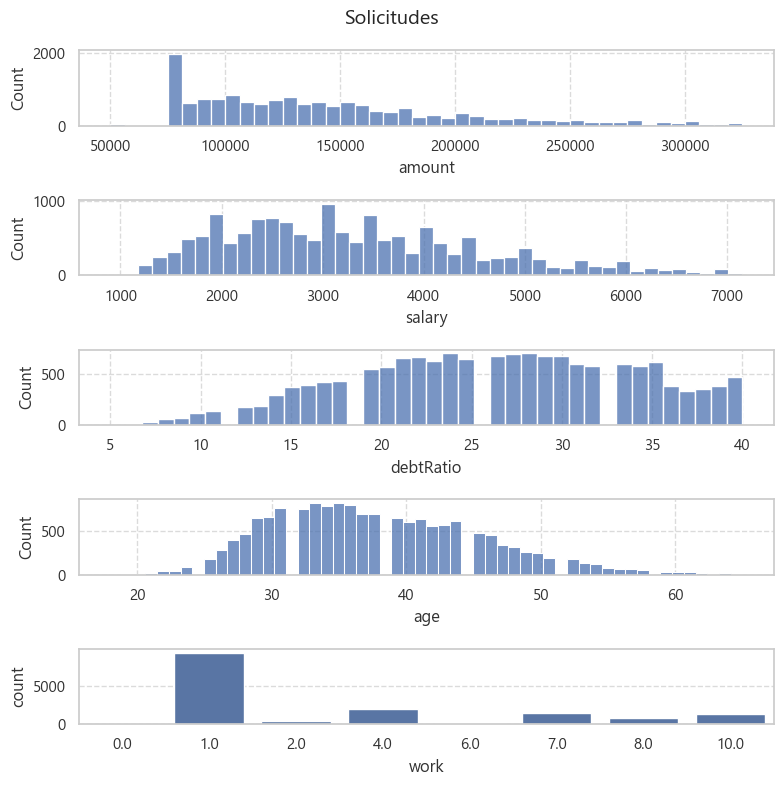

In [99]:
# Primero qué tipo de cliente se interesa por nuestra empresa:
fig, ax = plt.subplots(5, 1, figsize=(8,8))
fig.suptitle('Solicitudes')
sns.histplot(data=df_solicitudes_unicas, x='amount', ax=ax[0])
sns.histplot(data=df_solicitudes_unicas, x='salary', ax=ax[1])
sns.histplot(data=df_solicitudes_unicas, x='debtRatio', ax=ax[2])
sns.histplot(data=df_solicitudes_unicas, x='age', ax=ax[3])
sns.countplot(data=df_solicitudes_unicas, x='work', ax=ax[4])

plt.tight_layout()

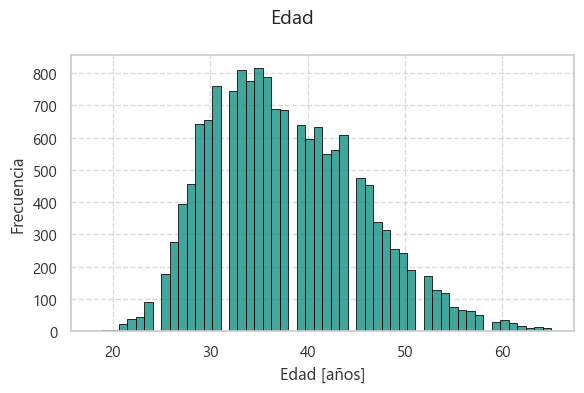

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
fig.suptitle('Edad')
sns.histplot(data=df_solicitudes_unicas, x='age', ax=ax, color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax.set_xlabel('Edad [años]')
ax.set_ylabel('Frecuencia')
plt.tight_layout()

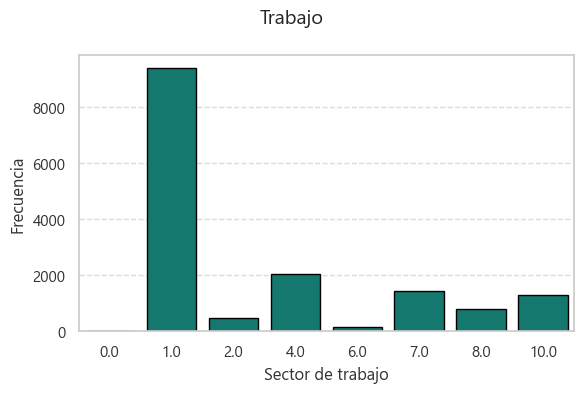

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
fig.suptitle('Trabajo')
sns.countplot(data=df_solicitudes_unicas, x='work', ax=ax, color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax.set_xlabel('Sector de trabajo')
ax.set_ylabel('Frecuencia')

plt.tight_layout()

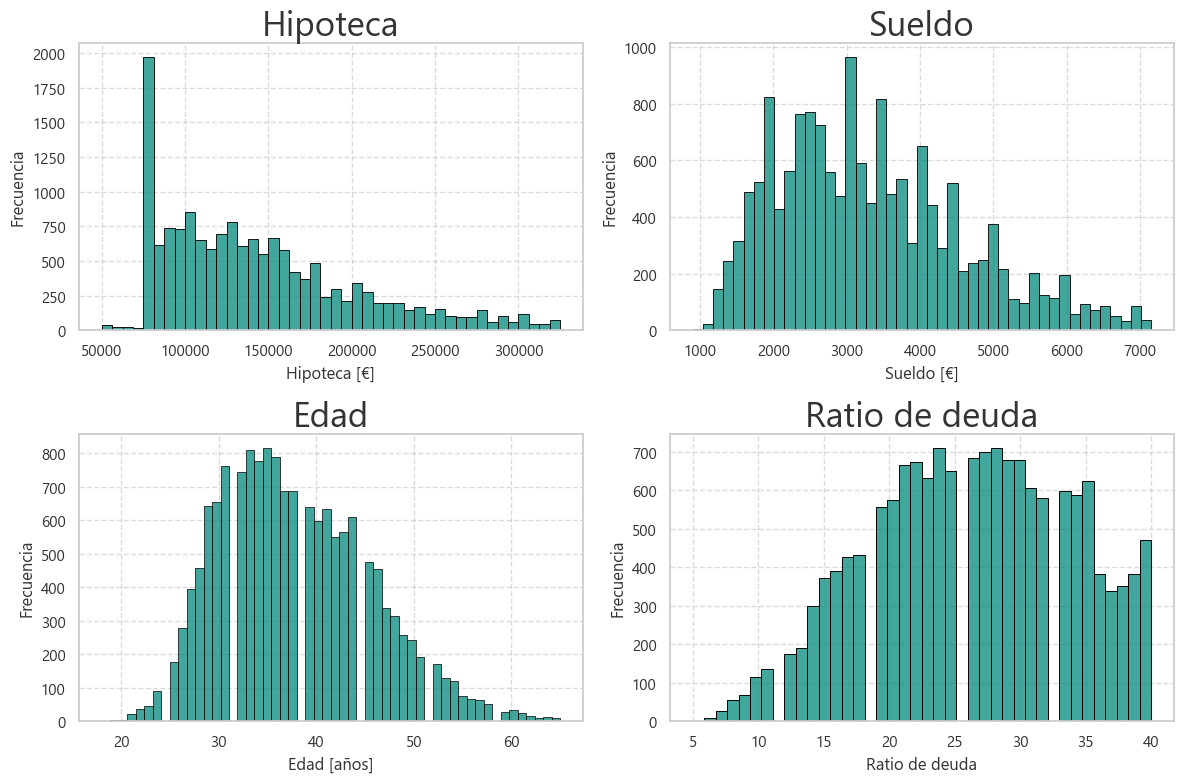

In [158]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
#fig.suptitle('Trabajo')
sns.histplot(data=df_solicitudes_unicas, x='amount', ax=ax[0,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[0,0].set_xlabel('Hipoteca [€]')
ax[0,0].set_ylabel('Frecuencia')
ax[0,0].set_title('Hipoteca', fontsize=25)

sns.histplot(data=df_solicitudes_unicas, x='salary', ax=ax[0,1], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[0,1].set_xlabel('Sueldo [€]')
ax[0,1].set_ylabel('Frecuencia')
ax[0,1].set_title('Sueldo', fontsize=25)

sns.histplot(data=df_solicitudes_unicas, x='age', ax=ax[1,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[1,0].set_xlabel('Edad [años]')
ax[1,0].set_ylabel('Frecuencia')
ax[1,0].set_title('Edad', fontsize=25)

sns.histplot(data=df_solicitudes_unicas, x='debtRatio', ax=ax[1,1], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[1,1].set_xlabel('Ratio de deuda')
ax[1,1].set_ylabel('Frecuencia')
ax[1,1].set_title('Ratio de deuda', fontsize=25)


plt.tight_layout() 

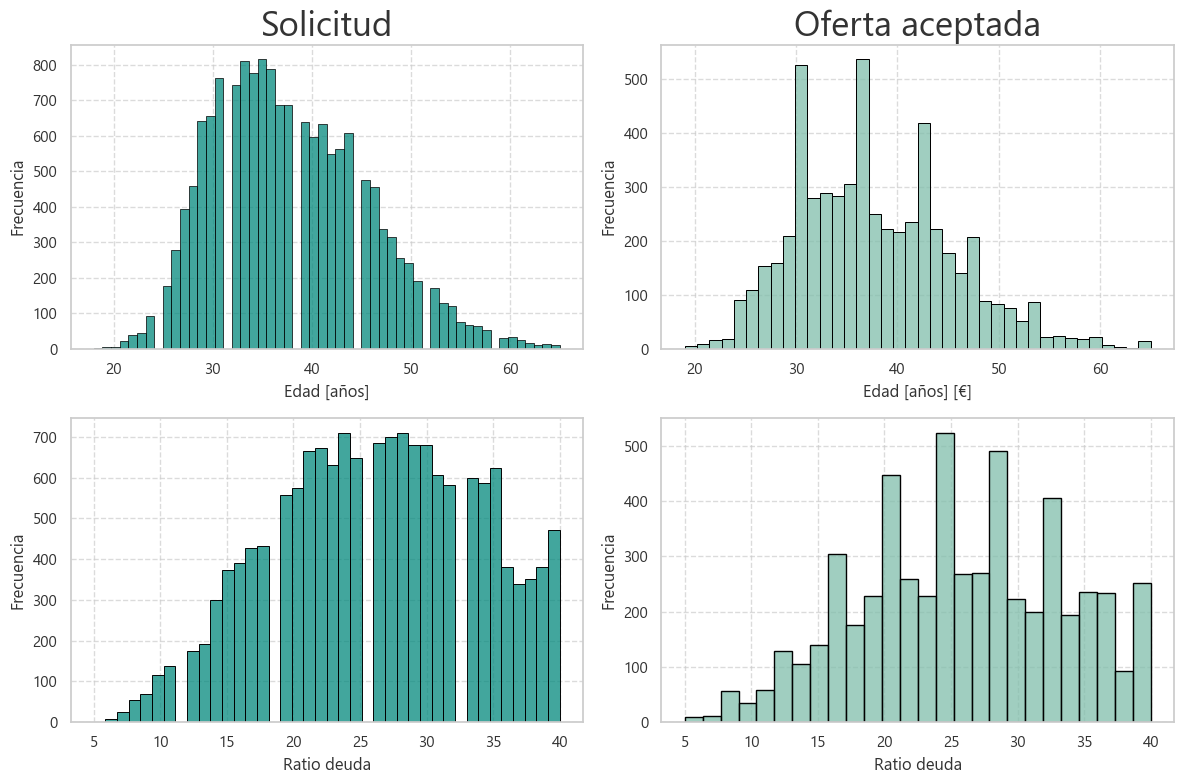

In [165]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
#fig.suptitle('Trabajo')
sns.histplot(data=df_solicitudes_unicas, x='age', ax=ax[0,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[0,0].set_xlabel('Edad [años]')
ax[0,0].set_ylabel('Frecuencia')
ax[0,0].set_title('Solicitud', fontsize=25)

sns.histplot(data=df_aceptados_unicos, x='age', ax=ax[0,1], color=COLORES_COLIBID['secondary'], edgecolor='black')
ax[0,1].set_xlabel('Edad [años] [€]')
ax[0,1].set_ylabel('Frecuencia')
ax[0,1].set_title('Oferta aceptada', fontsize=25)

sns.histplot(data=df_solicitudes_unicas, x='debtRatio', ax=ax[1,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[1,0].set_xlabel('Ratio deuda')
ax[1,0].set_ylabel('Frecuencia')
#ax[1,0].set_title('Edad', fontsize=25)

sns.histplot(data=df_aceptados_unicos, x='debtRatio', ax=ax[1,1], color=COLORES_COLIBID['secondary'], edgecolor='black')
ax[1,1].set_xlabel('Ratio deuda')
ax[1,1].set_ylabel('Frecuencia')
#ax[1,1].set_title('Ratio de deuda', fontsize=25)

plt.tight_layout()

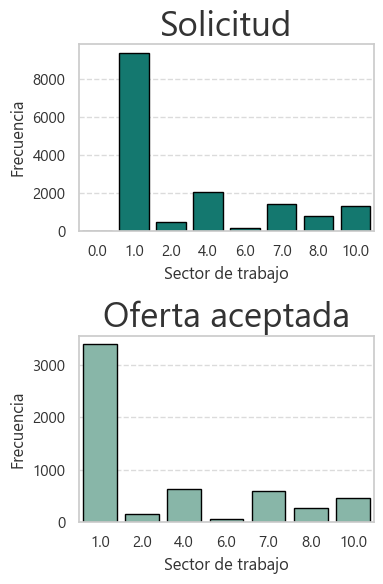

In [177]:
fig, ax = plt.subplots(2, 1, figsize=(4,6))
#fig.suptitle('Trabajo')
sns.countplot(data=df_solicitudes_unicas, x='work', ax=ax[0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax[0].set_xlabel('Sector de trabajo')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Solicitud', fontsize=25)

sns.countplot(data=df_aceptados_unicos, x='work', ax=ax[1], color=COLORES_COLIBID['secondary'], edgecolor='black')
ax[1].set_xlabel('Sector de trabajo')
ax[1].set_ylabel('Frecuencia')
ax[1].set_title('Oferta aceptada', fontsize=25)

plt.tight_layout()

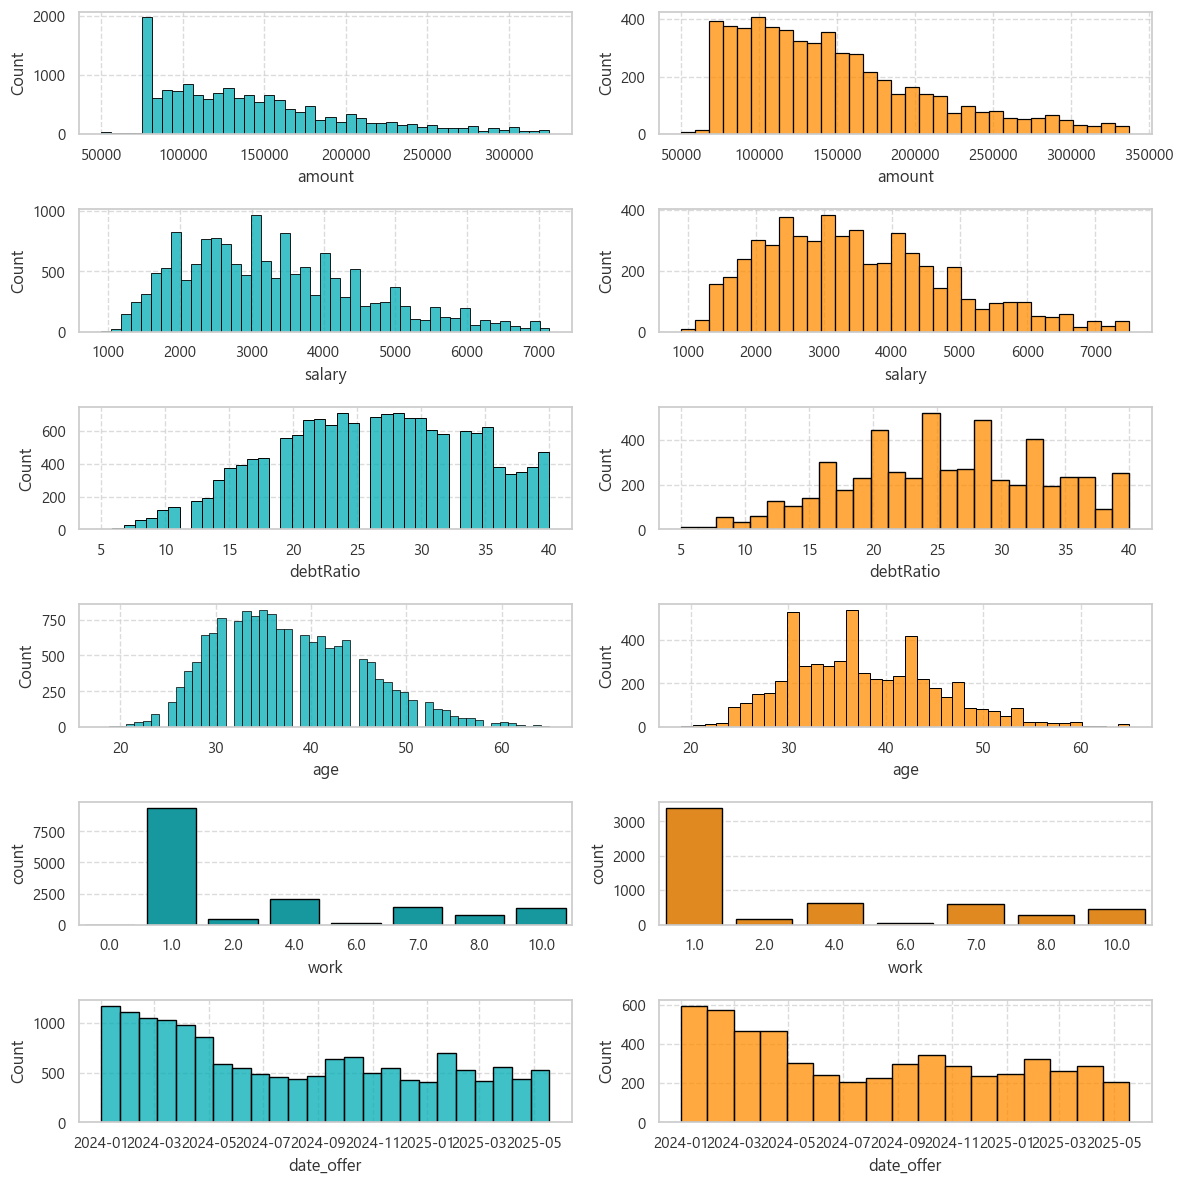

amount: Solicitud: 132000.0, aceptada: 135067.5, std_dev: -2592.6642777790767
salary: Solicitud: 3100.0, aceptada: 3300.0, std_dev: -77.97108977979997
debtRatio: Solicitud: 26.0, aceptada: 26.0, std_dev: 0.09393784590802934
age: Solicitud: 37.0, aceptada: 37.0, std_dev: 0.08419344335514278


In [121]:
fig, ax = plt.subplots(6, 2, figsize=(12, 12))
# fig.suptitle('Solicitudes')
sns.histplot(data=df_solicitudes_unicas, x='amount', ax=ax[0,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
sns.histplot(data=df_solicitudes_unicas, x='salary', ax=ax[1,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
sns.histplot(data=df_solicitudes_unicas, x='debtRatio', ax=ax[2,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
sns.histplot(data=df_solicitudes_unicas, x='age', ax=ax[3,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
sns.countplot(data=df_solicitudes_unicas, x='work', ax=ax[4,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
sns.histplot(data=df_solicitudes_unicas, x='date_offer', ax=ax[5,0], color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')

sns.histplot(data=df_aceptados_unicos, x='amount', ax=ax[0,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')
sns.histplot(data=df_aceptados_unicos, x='salary', ax=ax[1,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')
sns.histplot(data=df_aceptados_unicos, x='debtRatio', ax=ax[2,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')
sns.histplot(data=df_aceptados_unicos, x='age', ax=ax[3,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')
sns.countplot(data=df_aceptados_unicos, x='work', ax=ax[4,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')
sns.histplot(data=df_aceptados_unicos, x='date_offer', ax=ax[5,1], color=COLORES_COLIBID['secondary_orange'], edgecolor='black')

plt.tight_layout()
plt.savefig('PrimeraComparacion.png')
plt.show()


for column in columns:
    print(f"""{column}: Solicitud: {df_solicitudes_unicas[column].median()}, aceptada: {df_aceptados_unicos[column].median()}, std_dev: {df_solicitudes_unicas[column].std() - df_aceptados_unicos[column].std()}""")

In [101]:
# Asume que df_solicitudes_unicas y df_aceptados_unicos ya están definidos
columns = ['amount', 'salary', 'debtRatio', 'age']

for column in columns:
    print(f"\n--- Análisis de la Columna: {column} ---")

    # Calculamos las métricas para cada grupo
    median_solicitudes = df_solicitudes_unicas[column].median()
    median_aceptados = df_aceptados_unicos[column].median()

    mean_solicitudes = df_solicitudes_unicas[column].mean()
    mean_aceptados = df_aceptados_unicos[column].mean()

    std_solicitudes = df_solicitudes_unicas[column].std()
    std_aceptados = df_aceptados_unicos[column].std()

    q1_solicitudes = df_solicitudes_unicas[column].quantile(0.25)
    q1_aceptados = df_aceptados_unicos[column].quantile(0.25)

    q3_solicitudes = df_solicitudes_unicas[column].quantile(0.75)
    q3_aceptados = df_aceptados_unicos[column].quantile(0.75)

    # Coeficiente de Variación (CV), usa la media como denominador
    cv_solicitudes = (std_solicitudes / mean_solicitudes) * 100 if mean_solicitudes != 0 else np.nan
    cv_aceptados = (std_aceptados / mean_aceptados) * 100 if mean_aceptados != 0 else np.nan

    # Imprimimos los resultados para una fácil comparación
    print(f"  Métrica        | Solicitudes         | Aceptados           | Diferencia (Aceptados - Solicitudes)")
    print(f"-----------------|---------------------|---------------------|--------------------------------------")
    print(f"  Mediana        | {median_solicitudes:<19.2f} | {median_aceptados:<19.2f} | {median_aceptados - median_solicitudes:<25.2f}")
    print(f"  Media          | {mean_solicitudes:<19.2f} | {mean_aceptados:<19.2f} | {mean_aceptados - mean_solicitudes:<25.2f}")
    print(f"  Std Dev        | {std_solicitudes:<19.2f} | {std_aceptados:<19.2f} | {std_aceptados - std_solicitudes:<25.2f}")
    print(f"  Q1 (25%)       | {q1_solicitudes:<19.2f} | {q1_aceptados:<19.2f} | {q1_aceptados - q1_solicitudes:<25.2f}")
    print(f"  Q3 (75%)       | {q3_solicitudes:<19.2f} | {q3_aceptados:<19.2f} | {q3_aceptados - q3_solicitudes:<25.2f}")
    print(f"  CV (%)         | {cv_solicitudes:<19.2f} | {cv_aceptados:<19.2f} | {cv_aceptados - cv_solicitudes:<25.2f}")


--- Análisis de la Columna: amount ---
  Métrica        | Solicitudes         | Aceptados           | Diferencia (Aceptados - Solicitudes)
-----------------|---------------------|---------------------|--------------------------------------
  Mediana        | 132000.00           | 135067.50           | 3067.50                  
  Media          | 144032.38           | 148197.57           | 4165.19                  
  Std Dev        | 58572.01            | 61164.67            | 2592.66                  
  Q1 (25%)       | 97000.00            | 100000.00           | 3000.00                  
  Q3 (75%)       | 175750.00           | 180000.00           | 4250.00                  
  CV (%)         | 40.67               | 41.27               | 0.61                     

--- Análisis de la Columna: salary ---
  Métrica        | Solicitudes         | Aceptados           | Diferencia (Aceptados - Solicitudes)
-----------------|---------------------|---------------------|-----------------------

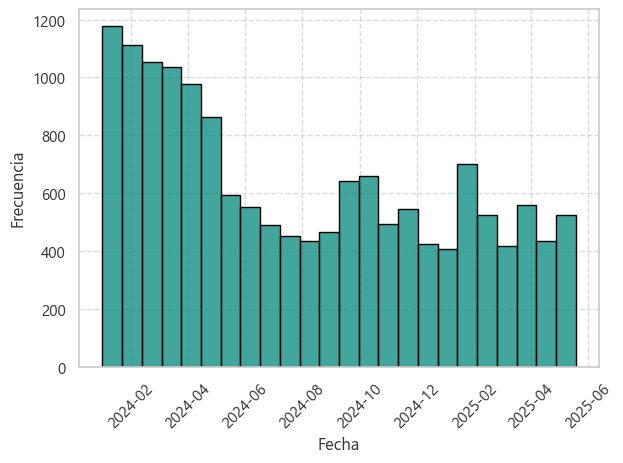

In [195]:
import matplotlib.dates as mdates
ax = sns.histplot(df_solicitudes_unicas['date_offer'], 
            color=COLORES_COLIBID['primary_blue_green'],
            edgecolor='black')

ax.set_ylabel('Frecuencia')
ax.set_xlabel('Fecha')

# Formatear el eje X
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # cada 2 meses
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)  # rotar para mejor lectura

plt.tight_layout()
plt.show()

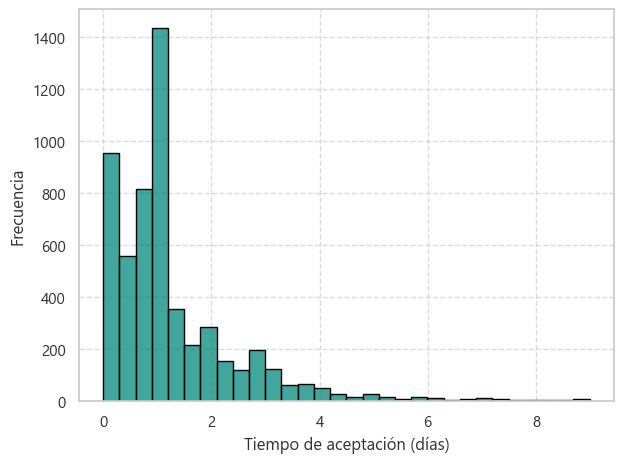

In [207]:
df_aceptados_unicos['tiempo_aceptacion'] = (df_aceptados_unicos['date_accepted'] - df_aceptados_unicos['date_offer']).dt.total_seconds() / (60 * 60 * 24)
df_aceptados_unicos.shape

# Now plot it
ax = sns.histplot(
    df_aceptados_unicos['tiempo_aceptacion'], 
    color=COLORES_COLIBID['primary_blue_green'],
    edgecolor='black',
    bins=30  # optional: set number of bins
)

ax.set_xlabel('Tiempo de aceptación (días)')
ax.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

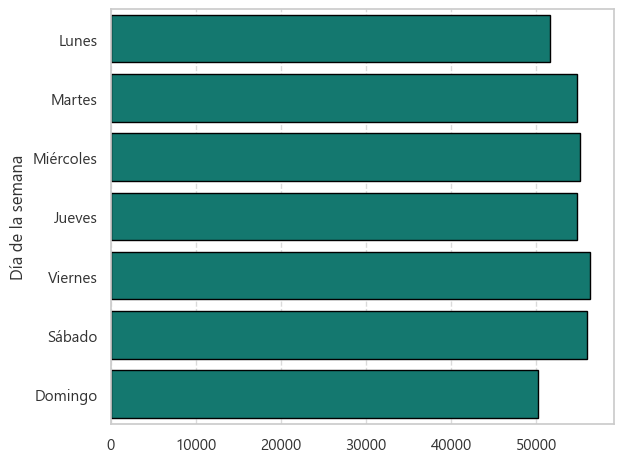

In [185]:
ax = sns.barplot(df_solicitudes_unicas['date_offer'].dt.day_name(), 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            errorbar=None,
            color=COLORES_COLIBID['primary_blue_green'],
            edgecolor='black')
ax.set_ylabel('Día de la semana')

# Set Spanish labels safely
spanish_labels = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
ax.set_yticks(range(len(spanish_labels)))  # set fixed tick positions
ax.set_yticklabels(spanish_labels)    

plt.tight_layout()
plt.show()

#### Intentamos localizar las hipotecas en un mapa

In [103]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

In [104]:
df_locs = pd.DataFrame(df_solicitudes_unicas.groupby('zipcode')['id_oferta'].count().sort_values(ascending=False)).reset_index()

In [105]:
df_locs.columns=['zipcode', 'counts']

In [106]:
df_excel = pd.read_excel('data/Listado-de-CP.xlsx')
df_excel.head()

,codigo_postal,municipio_id,codigo_unidad_poblacional,entidad_singular_nombre,nucleo_nombre,Latitud,Longitud
0,1001,1059,63501,Vitoria-Gasteiz,Vitoria-Gasteiz,42.848539,-2.672299
1,1002,1059,63501,Vitoria-Gasteiz,Vitoria-Gasteiz,42.853755,-2.657399
2,1003,1059,63501,Vitoria-Gasteiz,Vitoria-Gasteiz,42.845374,-2.651191
3,1004,1059,63501,Vitoria-Gasteiz,Vitoria-Gasteiz,42.844406,-2.666711
4,1005,1059,63501,Vitoria-Gasteiz,Vitoria-Gasteiz,42.843667,-2.672299


In [107]:
df_excel.loc[df_excel['codigo_postal'] == 46910, :]
df_excel.info()
df_excel['codigo_postal'] = df_excel['codigo_postal'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11241 entries, 0 to 11240
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   codigo_postal              11241 non-null  int64  
 1   municipio_id               11241 non-null  int64  
 2   codigo_unidad_poblacional  11241 non-null  int64  
 3   entidad_singular_nombre    11241 non-null  object 
 4   nucleo_nombre              11234 non-null  object 
 5   Latitud                    11238 non-null  float64
 6   Longitud                   11238 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 614.9+ KB


In [108]:
df_locs2 = pd.merge(left=df_locs, right=df_excel, left_on='zipcode', right_on='codigo_postal', how='inner')
df_locs = df_locs2.drop(['codigo_postal', 'municipio_id', 'codigo_unidad_poblacional', 'entidad_singular_nombre'], axis=1)
df_locs


,zipcode,counts,nucleo_nombre,Latitud,Longitud
0,28031,118,Madrid,40.380916,-3.586331
1,28850,65,Torrejon de Ardoz,40.471568,-3.449835
2,28021,61,Madrid,40.336660,-3.697826
3,46900,57,*Diseminado*,39.407690,-0.502159
4,28039,50,Madrid,40.460972,-3.710512
...,...,...,...,...,...
2242,50740,1,Fuentes de Ebro,41.459601,-0.620416
2243,50720,1,Ricla,41.538678,-0.772297
2244,50694,1,Bardenas,42.199098,-1.318004
2245,50692,1,Joyosa (La),41.750590,-1.082563


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\2018403085.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



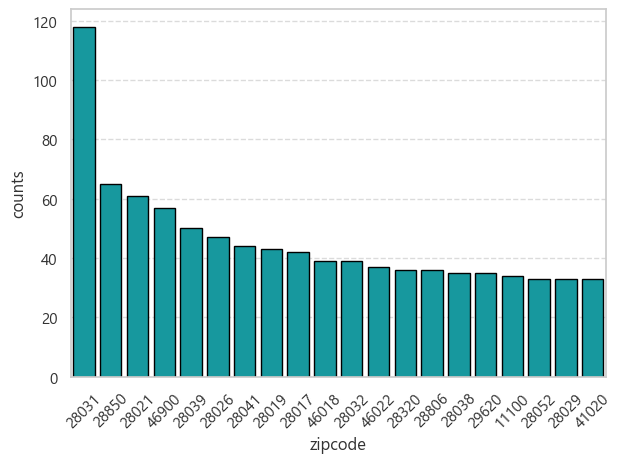

In [126]:
fig, ax = plt.subplots(1,1)
sns.barplot(data=df_locs.iloc[:20, :], x='zipcode', y='counts', errorbar=None, color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

In [110]:
df_locs_plot = pd.DataFrame(df_locs.groupby('nucleo_nombre')['zipcode'].count().sort_values(ascending=False)).reset_index()
df_locs_plot.columns=['nombre_nucleo', 'counts']


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\926818621.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



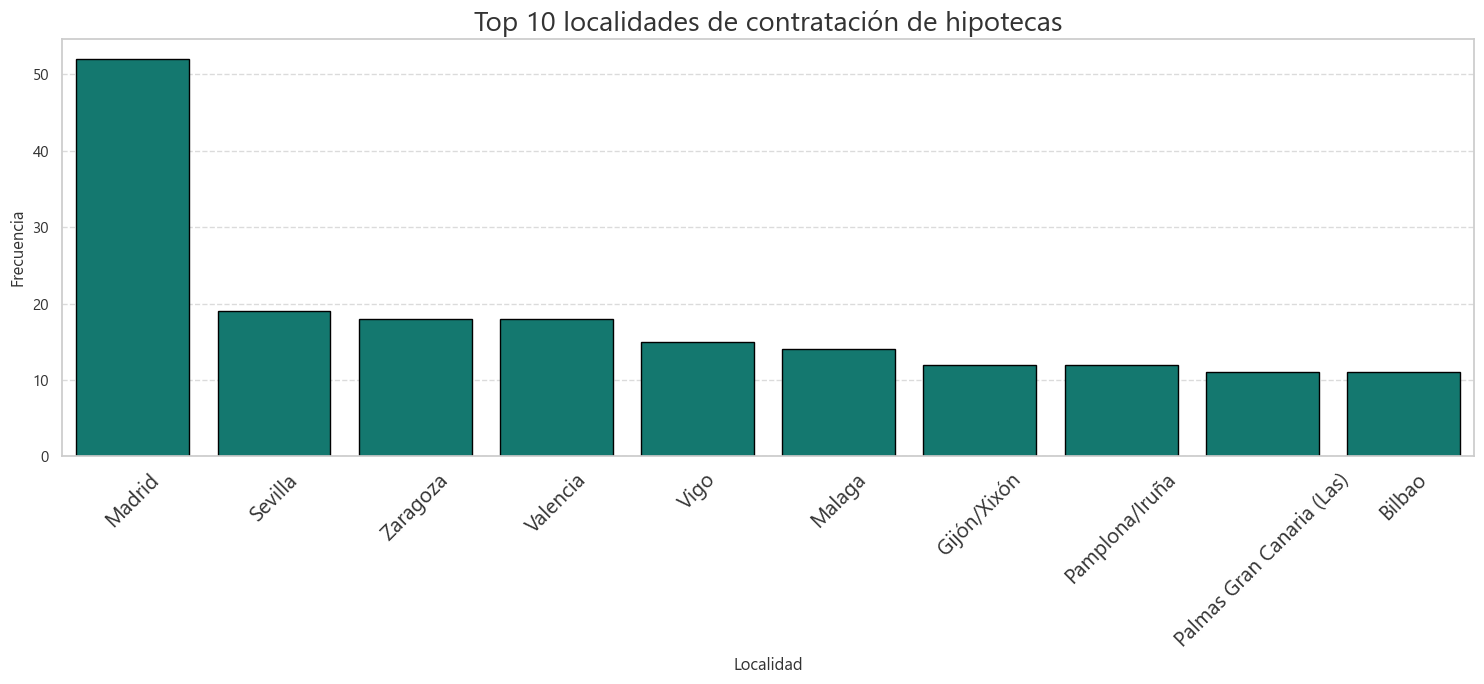

In [221]:
fig, ax = plt.subplots(1,1, figsize = (15, 7))
sns.barplot(data=df_locs_plot.iloc[1:11, :], x='nombre_nucleo', y='counts', errorbar=None, color=COLORES_COLIBID['primary_blue_green'], edgecolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15)
ax.set_xlabel('Localidad')
ax.set_ylabel('Frecuencia')
ax.set_title('Top 10 localidades de contratación de hipotecas', fontsize=20)
plt.tight_layout()

In [112]:
fig_scatter = px.scatter_mapbox(df_locs,
                                lat='Latitud',
                                lon='Longitud',
                                color='counts',
                                color_continuous_scale=px.colors.sequential.YlOrRd, # Escala de colores (amarillo a rojo)
                                size_max=30, # Tamaño máximo de los marcadores para evitar que sean demasiado grandes
                                zoom=5.5, # Nivel de zoom inicial (ajusta según tu región)
                                # Centra el mapa en la media de tus puntos para una vista general
                                center={"lat": df_locs['Latitud'].mean(), "lon": df_locs['Longitud'].mean()},
                                mapbox_style="open-street-map", # Estilo de mapa base (no requiere clave de Mapbox)
                                title=f"Puntos Calientes de Actividad Hipotecaria por Código Postal (España)"
                               )

# Ajustes adicionales para el layout del mapa
fig_scatter.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title='cuentas',
        tickformat="," # Formato para los números en la leyenda de color
    )
)

fig_scatter.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\598653460.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [212]:
fig_density = px.density_mapbox(df_locs,
                                lat="Latitud",
                                lon="Longitud",
                                z='counts', # Variable que define la intensidad del calor
                                radius=20, # Ajusta el radio de los puntos de calor (mayor radio = calor más extendido)
                                color_continuous_scale=px.colors.sequential.Teal,#['#E5F5F1', '#80BEAB', '#03897D'],#px.colors.sequential.Hot, # Otra buena escala de colores para calor
                                zoom=5.5,
                                center={"lat": df_locs['Latitud'].mean(), "lon": df_locs['Longitud'].mean()},
                                mapbox_style="open-street-map",
                                title=f"Mapa de Densidad de Actividad Hipotecaria por Código Postal (España)"
                               )

fig_density.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title='Número de hipotecas',
        tickformat="," # Formato para los números en la leyenda de color
    ))
fig_density.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_18148\1916243284.py:1: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

